OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August, September 2022

## Predict CO2 using predicted energies

### Introduction

#### Importing libraries

In [97]:
%reset -f

import pickle

import warnings
warnings.filterwarnings(action="ignore")

from evaluate import *

from os import listdir
from os.path import isfile, join

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [98]:
# Heure démarrage
t0 = time()

seed = 1
print("Seed value: ", seed)

Seed value:  1


#### Loading dataset

In [99]:
target = "Log-TotalGHGEmissions"
target_dir = "CO2_EnergyStarScore"

In [100]:
train_CO2_file = "dataset/{}/train_EnergyStarScore.csv".format(target_dir)
test_CO2_file = "dataset/{}/test_EnergyStarScore.csv".format(target_dir)

train_CO2 = pd.read_csv(train_CO2_file, sep=",")
test_CO2 = pd.read_csv(test_CO2_file, sep=",")

In [101]:
display(train_CO2)

,Ratio_Electricity,Ratio_Steam,Ratio_Gas,Ratio_Steam+Gas,ENERGYSTARScore,Log-TotalGHGEmissions
0,-0.40445,-0.05412,0.31332,0.43969,0.80408,5.48641
1,-1.85411,-0.24910,1.72909,1.78923,-0.57948,3.32251
2,1.17128,-0.28320,-1.17493,-1.18539,-0.31772,2.54003
3,-1.30127,-0.24959,1.58624,1.36932,0.91626,3.03303
4,1.22948,-0.00189,-1.36394,-1.29871,0.05621,5.82591
...,...,...,...,...,...,...
1654,1.47663,-0.28320,-1.59880,-1.51315,0.35536,1.49962
1655,-0.45911,-0.28320,0.21684,0.32485,1.21541,4.12017
1656,-2.74508,-0.21158,2.44909,2.77751,0.46754,3.88445
1657,0.33018,0.42960,-0.49374,-0.46357,0.80408,4.24878


#### Separating features and target vectors

In [102]:
features_for_prediction = ["Ratio_Electricity", "Ratio_Gas", "Ratio_Steam", "ENERGYSTARScore"]
#features_for_prediction = ["Ratio_Electricity", "Ratio_Gas", "Ratio_Steam", "Ratio_Steam+Gas", "ENERGYSTARScore"]

In [103]:
#X_train = train_CO2.iloc[:, :-1] # all rows, 51 columns (not last five)
#X_test = test_CO2.iloc[:, :-1]

X_train = train_CO2[features_for_prediction]
X_test = test_CO2[features_for_prediction]

y_train = train_CO2[target]
y_test = test_CO2[target]

In [104]:
X_train

,Ratio_Electricity,Ratio_Gas,Ratio_Steam,ENERGYSTARScore
0,-0.40445,0.31332,-0.05412,0.80408
1,-1.85411,1.72909,-0.24910,-0.57948
2,1.17128,-1.17493,-0.28320,-0.31772
3,-1.30127,1.58624,-0.24959,0.91626
4,1.22948,-1.36394,-0.00189,0.05621
...,...,...,...,...
1654,1.47663,-1.59880,-0.28320,0.35536
1655,-0.45911,0.21684,-0.28320,1.21541
1656,-2.74508,2.44909,-0.21158,0.46754
1657,0.33018,-0.49374,0.42960,0.80408


In [105]:
y_train

0      5.48641
1      3.32251
2      2.54003
3      3.03303
4      5.82591
         ...  
1654   1.49962
1655   4.12017
1656   3.88445
1657   4.24878
1658   1.35067
Name: Log-TotalGHGEmissions, Length: 1659, dtype: float64

In [106]:
X_test

,Ratio_Electricity,Ratio_Gas,Ratio_Steam,ENERGYSTARScore
0,-1.03489,1.04374,-0.25608,0.99105
1,0.03039,0.05406,-0.24959,-1.14038
2,1.34028,-1.35000,-0.28320,0.95366
3,0.74046,-0.92506,-0.21522,-0.65426
4,0.69091,-0.55755,-0.28320,0.28058
...,...,...,...,...
706,-0.75533,0.71345,0.65647,-0.76644
707,0.12343,0.19935,-0.29494,0.95366
708,1.21670,-1.36394,-0.00189,0.99105
709,-2.33722,2.27158,-0.24910,0.69190


In [107]:
print("The shape of the training matrix :", X_train.shape, "and this is the shape of the target vector :", y_train.shape)
print("The shape of the test matrix :", X_test.shape, "and this is the shape of the target vector :", y_test.shape)

The shape of the training matrix : (1659, 4) and this is the shape of the target vector : (1659,)
The shape of the test matrix : (711, 4) and this is the shape of the target vector : (711,)


## Trying linear models and ensemble methods

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

### 0) Before starting : CV, Baselines

#### Evaluation metric

In [109]:
# Setting evaluation metric for regression
scoring = 'r2'

#### Cross-Validation

In [110]:
# Define the cross-validation generator
#cv_inner = KFold(n_splits=10, # number of folds (default=5)
                 #shuffle=True, # shuffle the data before splitting into batche
                 #random_state=seed) # seeding the random number generator for shuffling

# define model evaluation method
#cv = RepeatedKFold(n_splits=10,
 #                  n_repeats=3,
  #                 random_state=seed)

# step-1: create a cross-validation scheme / # create a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=seed)

#### Baseline : Dummy Regressor

Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.34684,1.81397,1.12247,1.06527,-0.00017


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.34684,1.81397,1.12247,1.06527,-0.00017


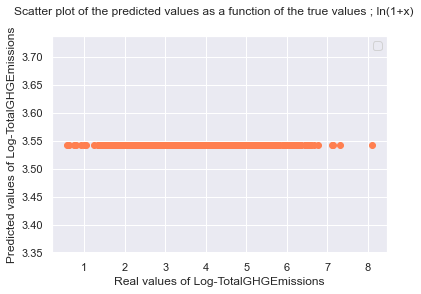

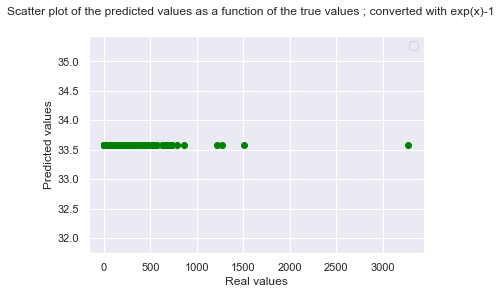

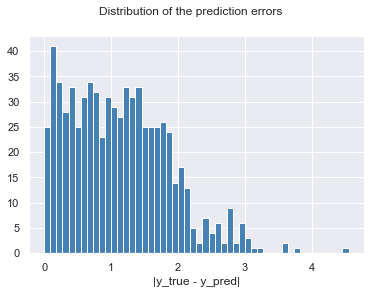

In [111]:
from sklearn import dummy

# 0) We create a dummy regressor model that always predicts the mean value of the feature to predict
dum = dummy.DummyRegressor(strategy='mean')

# 1) Training Dummy Regression
dum.fit(X_train, y_train)

# 2) Prediction on the testing set
y_pred_dum = dum.predict(X_test)

# 3) Evaluate
evaluate_regression("Dummy Regressor", results, y_test, y_pred_dum)

#### Baseline : Linear Regression

R2 : 0.25851069266815563
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Linear Regression,1.15966,1.34481,0.93806,0.84323,0.25851


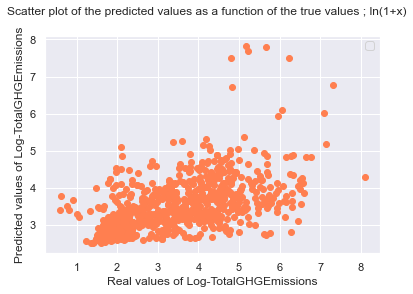

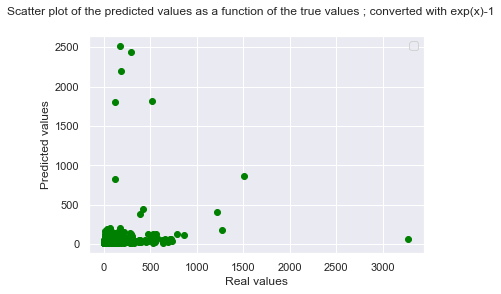

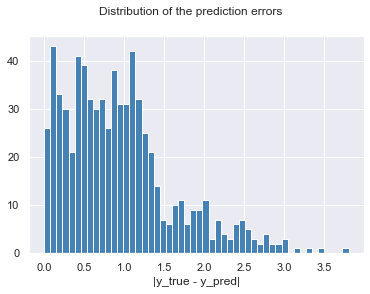

In [112]:
from sklearn import linear_model

# 0) We create a linear regression model
lr = linear_model.LinearRegression()

# 1) Training Linear Regression and Evaluating
reg = lr.fit(X_train, y_train)
y_pred_lr = reg.predict(X_test)

prediction_score = lr.score(X_test, y_test)
print('R2 : {}'.format(prediction_score))

results = evaluate_regression("Linear Regression", results, y_test, y_pred_lr)

##### Baseline Linear Regression with Cross Valisation

In [113]:
lr_scores = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='r2', cv=folds, n_jobs=-1)
lr_mean_cv_score = np.mean(lr_scores)
print("Linear Regression CV :", lr_mean_cv_score)

results_cv = summary_results_cv("Linear Regression CV", lr_mean_cv_score, results_cv)

Linear Regression CV : 0.2753554756430801
Results Cross-Validated


,Model,Mean CV R²
0,Linear Regression CV,0.27536


#### Baseline score and scoring metric for evaluation

In [114]:
baseline_error = mean_squared_error(y_test, y_pred_lr)
print("Baseline error = MSE from Linear Regression :", baseline_error)

Baseline error = MSE from Linear Regression : 1.3448134951692732


### 1) Linear Model : Ridge Regression


#### 1.1) Trying Ridge Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [115]:
a, b = -2, 2
n_alphas = 50 # hyperparametre alpha
alphas = np.logspace(a, b, n_alphas)

ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    coefs.append(ridge.coef_)
    errors.append(np.mean((y_pred_ridge - y_test) ** 2))
    #print("HERE :", np.mean(( - y_test) ** 2), "MSE :", mean_squared_error(y_test, ridge.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for Ridge Regression : 1.3411078285726108
Best alpha for that minimal MSE :  100.0


(0.00630957344480193,
 158.48931924611142,
 1.3409225452427778,
 1.3449987784991062)

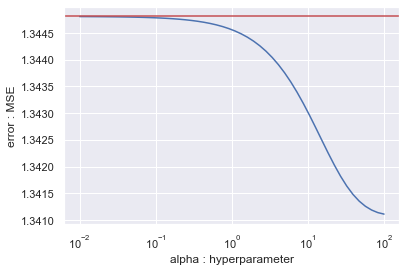

In [116]:
# recupere l'erreur min
print("Minimum Mean Squared Error for Ridge Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors)
# specifying horizontal line type
plt.axhline(y=baseline_error, color='r', linestyle='-')

ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(0.00630957344480193,
 158.48931924611142,
 -0.8566950589180822,
 0.48552858168302543)

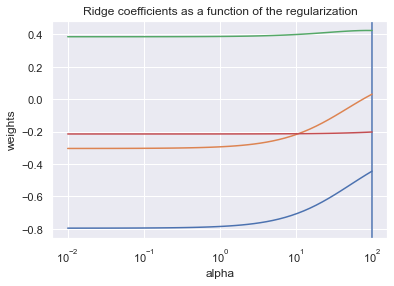

In [117]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

Getting y_pred for the best alpha :  100.0
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,1.15806,1.34111,0.93690,0.84755,0.26055
0,Linear Regression,1.15966,1.34481,0.93806,0.84323,0.25851


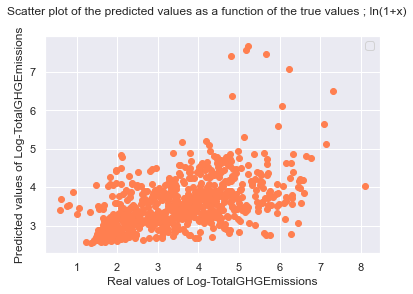

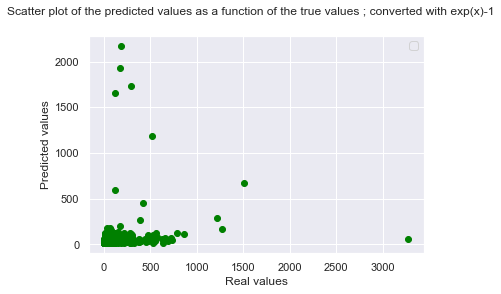

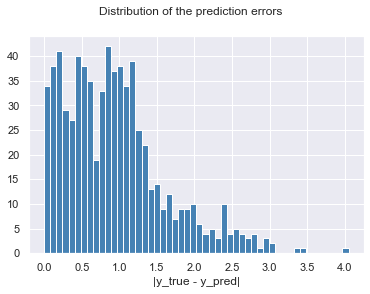

In [118]:
print("Getting y_pred for the best alpha : ", min_alpha)
ridge.set_params(alpha=min_alpha)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# 3) Evaluate
results = evaluate_regression("Ridge manually", results, y_test, y_pred_ridge)

##### 2.2) Optimization of hyperparameters

In [119]:
a, b = -2, 2
n_alphas = 50 # hyperparametre alpha

# define the model/ estimator
model = linear_model.Ridge()
params = {"alpha": np.logspace(a, b, n_alphas)} # alpha > 0

# define the grid search
Ridge_grid = GridSearchCV(
    model, params, scoring=scoring,
    cv=folds,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Ridge_grid.fit(X_train.values, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-01, 1.676832...
       1.93069773e+00, 2.32995181e+00, 2.81176870e+00, 3.39322177e+00,
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02])},
             return_train_score=True, scoring='r2', verbose=1)

Best estimator : Ridge(alpha=0.6250551925273969)
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,1.15806,1.34111,0.93690,0.84755,0.26055
0,Ridge GridSearchCV,1.15959,1.34466,0.93799,0.84348,0.25860
0,Linear Regression,1.15966,1.34481,0.93806,0.84323,0.25851


Results Cross-Validated


,Model,Mean CV R²
0,Ridge Regression CV,0.27536
0,Linear Regression CV,0.27536


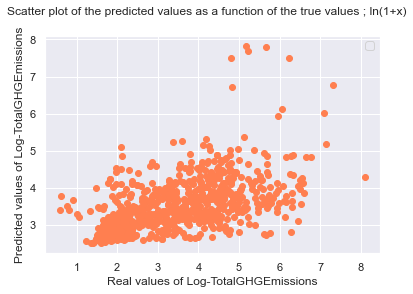

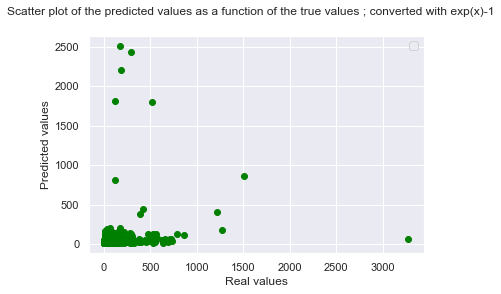

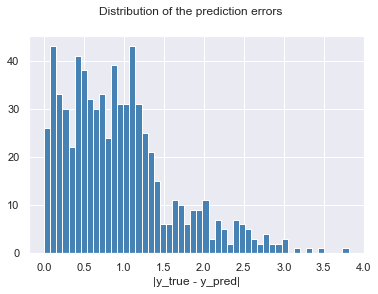

In [120]:
# best estimator
print("Best estimator :", Ridge_grid.best_estimator_)

# best model
best_model = Ridge_grid.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_ridge = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("Ridge GridSearchCV", results, y_test, y_pred_ridge)

results_cv = summary_results_cv("Ridge Regression CV", Ridge_grid.best_score_, results_cv)

#### 2) Linear Model : LASSO (Least Absolute Shrinkage and Selection Operator

##### 2.1) Trying LASSO Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [121]:
n_alphas = 50  # hyperparametre alpha
a, b = -5, -2
alphas = np.logspace(a, b, n_alphas)

lasso = linear_model.Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    coefs.append(lasso.coef_)
    errors.append(np.mean((y_pred_lasso - y_test) ** 2))
    #print("HERE :", np.mean((lasso.predict(X_test) - y_test) ** 2), "MSE :", mean_squared_error(y_test, lasso.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for LASSO Regression : 1.3403448325490661
Best alpha for that minimal MSE :  0.00868511373751352


(7.079457843841373e-06,
 0.01412537544622754,
 1.3401213994180559,
 1.3450369283002837)

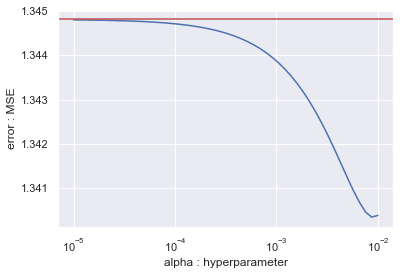

In [122]:
# recupere l'erreur min
print("Minimum Mean Squared Error for LASSO Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors)
plt.axhline(y=baseline_error, color='r', linestyle='-')
ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(7.079457843841373e-06,
 0.01412537544622754,
 -0.8568569179833042,
 0.49343750136812364)

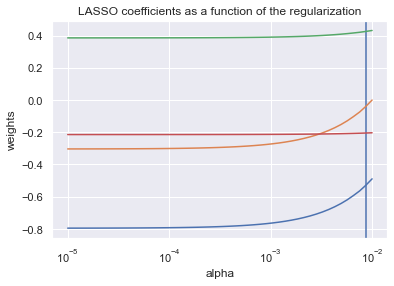

In [123]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

Getting y_pred for the best alpha :  0.00868511373751352
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,LASSO manually,1.15773,1.34034,0.93569,0.84865,0.26097
0,Ridge manually,1.15806,1.34111,0.93690,0.84755,0.26055
0,Ridge GridSearchCV,1.15959,1.34466,0.93799,0.84348,0.25860
0,Linear Regression,1.15966,1.34481,0.93806,0.84323,0.25851


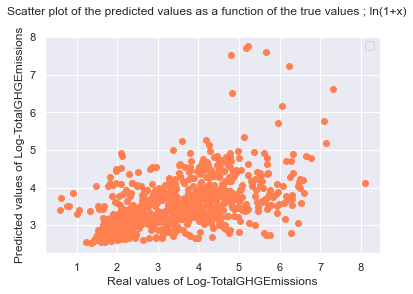

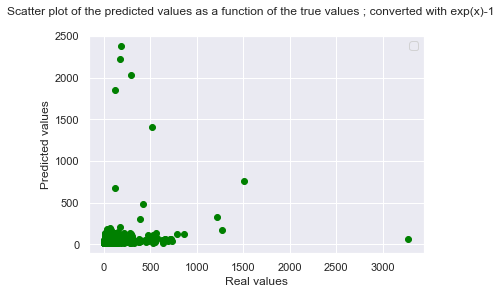

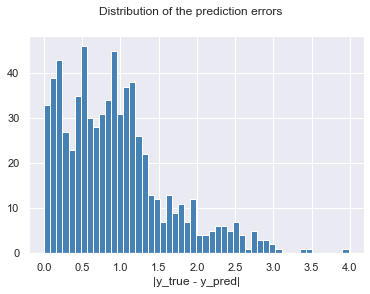

In [124]:
print("Getting y_pred for the best alpha : ", min_alpha)
lasso.set_params(alpha=min_alpha)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# 3) Evaluate
results = evaluate_regression("LASSO manually", results, y_test, y_pred_lasso)

##### 3.2) Optimization of hyperparameters

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best estimator : Lasso(alpha=0.0001)
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,LASSO manually,1.15773,1.34034,0.93569,0.84865,0.26097
0,Ridge manually,1.15806,1.34111,0.93690,0.84755,0.26055
0,Ridge GridSearchCV,1.15959,1.34466,0.93799,0.84348,0.25860
0,LASSO GridSearchCV,1.15962,1.34471,0.93802,0.84337,0.25857
0,Linear Regression,1.15966,1.34481,0.93806,0.84323,0.25851


Results Cross-Validated


,Model,Mean CV R²
0,Ridge Regression CV,0.27536
0,Linear Regression CV,0.27536
0,LASSO Regression CV,0.27534


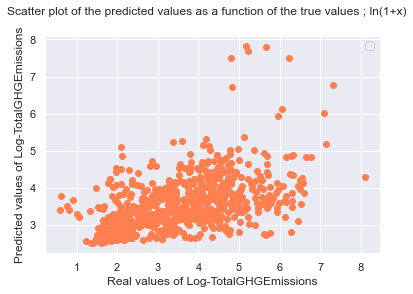

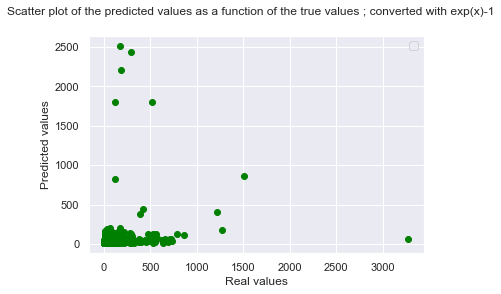

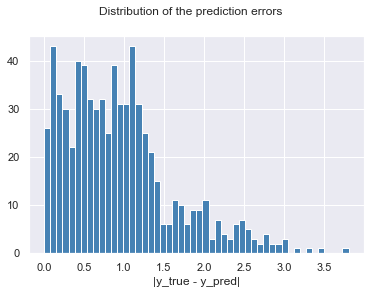

In [125]:
n_alphas = 50
a, b = -4, -2
params = {"alpha": np.logspace(a, b, n_alphas)}

# define the model/ estimator
model = linear_model.Lasso()

# define the grid search
Lasso_grid = GridSearchCV(
    model, params, scoring=scoring,
    cv=folds,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Lasso_grid.fit(X_train.values, y_train)

# best estimator
print("Best estimator :", Lasso_grid.best_estimator_)

# best model
best_model = Lasso_grid.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_lasso = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("LASSO GridSearchCV", results, y_test, y_pred_lasso)

results_cv = summary_results_cv("LASSO Regression CV", Lasso_grid.best_score_, results_cv)

#### 3) Linear Model : Elastic Net

##### 3.1) Preparation of the grid parameters

In [126]:
n = 100
# or : l1_ratio = [i / n for i in range(n)]
l1_ratio = np.arange(start=0, stop=1, step= 1/n)

a, b , n_alphas = -5, 5, 1000

param_grid_elastic = [{
    "alpha": np.logspace(a, b, n_alphas), # penalty intensity (5 values between 10⁻³ and 10¹)
    "l1_ratio": l1_ratio # mixing parameter for l1 and l2 penalties
}]

##### 3.2) Optimization of hyperparameters : RandomSearchCV

R2 : 0.25851654983202665 RMSE : 1.159656359545303 Best params : {'l1_ratio': 0.06, 'alpha': 2.2927693128656486e-05}
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,LASSO manually,1.15773,1.34034,0.93569,0.84865,0.26097
0,Ridge manually,1.15806,1.34111,0.93690,0.84755,0.26055
0,Ridge GridSearchCV,1.15959,1.34466,0.93799,0.84348,0.25860
0,LASSO GridSearchCV,1.15962,1.34471,0.93802,0.84337,0.25857
0,Elastic Net RandomSearchCV,1.15966,1.34480,0.93805,0.84325,0.25852
0,Linear Regression,1.15966,1.34481,0.93806,0.84323,0.25851


Results Cross-Validated


,Model,Mean CV R²
0,Ridge Regression CV,0.27536
0,Elastic Net RandomSearchCV,0.27536
0,Linear Regression CV,0.27536
0,LASSO Regression CV,0.27534


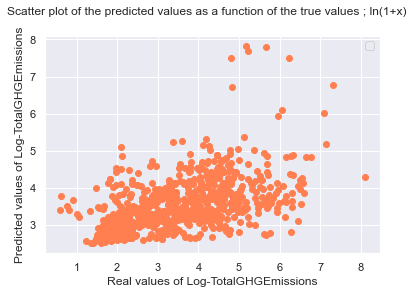

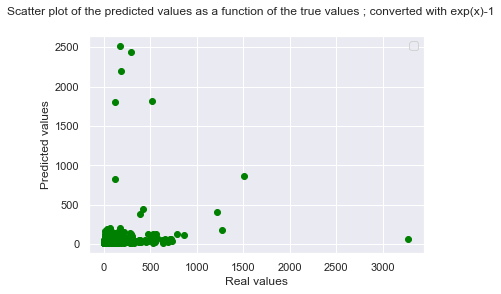

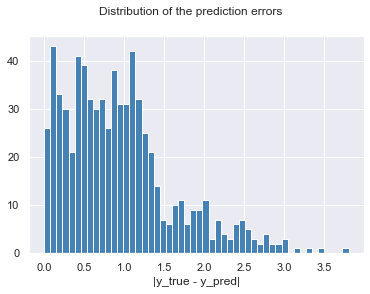

In [127]:
regressor = linear_model.ElasticNet()

# Intenciation of RandomizedSearchCV object
Elastic_RandomSearch_grid = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_grid_elastic, # choice of hyper-parameters to test
    scoring=scoring, # scoring method for regression
    cv=folds, # cross-validation generator
    n_jobs=-1, # use all available cores (parallelization)
    return_train_score=True, # to avoid a DeprecationWarning
    verbose=0,
    random_state=seed,

    n_iter=100, # number of combinations of hyper-parameters to try
    refit=True
)

# Call the RanddomizedSearch with Cross Validation using the chosen regressor
Elastic_RandomSearch_grid.fit(X_train, y_train)

# Results
y_pred_elastic = Elastic_RandomSearch_grid.predict(X_test)
R2_score = Elastic_RandomSearch_grid.score(X_test, y_test)
RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

print("R2 :", R2_score, "RMSE :", RMSE_score, "Best params :", Elastic_RandomSearch_grid.best_params_)
results = evaluate_regression("Elastic Net RandomSearchCV", results, y_test, y_pred_elastic)

results_cv = summary_results_cv("Elastic Net RandomSearchCV", Elastic_RandomSearch_grid.best_score_, results_cv)

##### 3.3) Optimization of hyperparameters : GridSearchCV

In [128]:
n = 10
# or : l1_ratio = [i / n for i in range(n)]
l1_ratio = np.arange(start=0, stop=1, step= 1/n)

a, b , n_alphas = -4, 2, 50

param_grid_elastic = [{
    "alpha": np.logspace(a, b, n_alphas), # penalty intensity (5 values between 10⁻³ and 10¹)
    "l1_ratio": l1_ratio # mixing parameter for l1 and l2 penalties
}]

R2 : 0.2586348277529853 RMSE : 1.3445883556619975
Best params : {'alpha': 0.0005428675439323859, 'l1_ratio': 0.0}
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,LASSO manually,1.15773,1.34034,0.93569,0.84865,0.26097
0,Ridge manually,1.15806,1.34111,0.93690,0.84755,0.26055
0,Elastic Net GridSearchCV,1.15956,1.34459,0.93796,0.84358,0.25863
0,Ridge GridSearchCV,1.15959,1.34466,0.93799,0.84348,0.25860
0,LASSO GridSearchCV,1.15962,1.34471,0.93802,0.84337,0.25857
0,Elastic Net RandomSearchCV,1.15966,1.34480,0.93805,0.84325,0.25852
0,Linear Regression,1.15966,1.34481,0.93806,0.84323,0.25851


Results Cross-Validated


,Model,Mean CV R²
0,Elastic Net GridSearchCV,0.27536
0,Ridge Regression CV,0.27536
0,Elastic Net RandomSearchCV,0.27536
0,Linear Regression CV,0.27536
0,LASSO Regression CV,0.27534


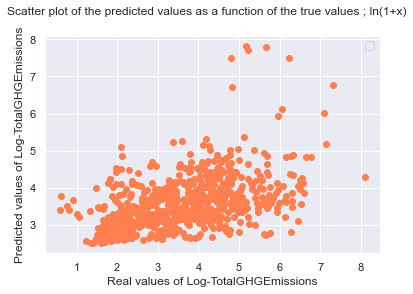

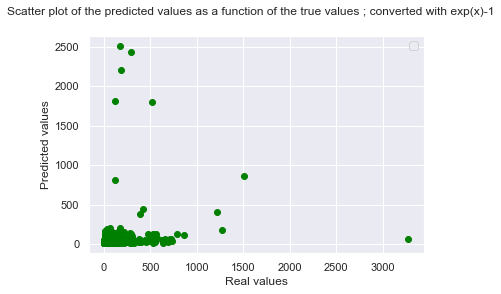

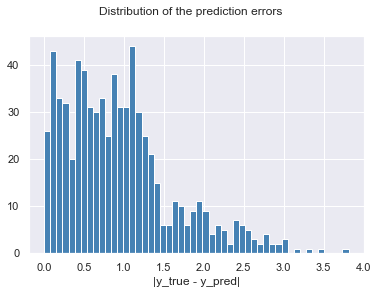

In [129]:
Elastic_GridSearch_grid= GridSearchCV(estimator=regressor,
                          param_grid=param_grid_elastic,
                          scoring=scoring,
                          cv=folds,
                          verbose=0,
                          n_jobs=-1,
                          return_train_score=True)

Elastic_GridSearch_grid.fit(X_train, y_train)

# Results
y_pred_elastic = Elastic_GridSearch_grid.predict(X_test)
R2_score = Elastic_GridSearch_grid.score(X_test, y_test)
MSE_score = mean_squared_error(y_test, y_pred_elastic)

print("R2 :", R2_score, "RMSE :", MSE_score)
print( "Best params :", Elastic_GridSearch_grid.best_params_)
#print("Train score :", Elastic_GridSearch_grid.cv_results_["mean_train_score"])

results = evaluate_regression("Elastic Net GridSearchCV", results, y_test, y_pred_elastic)

results_cv = summary_results_cv("Elastic Net GridSearchCV", Elastic_GridSearch_grid.best_score_, results_cv)

### 2) Ensemble learning methods

#### 1) Parallelized Implementation : Random Forest

In [130]:
# Grid of research for Random Forest
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()

# Create space of candidate values for hyperparameters

n_estimators = [10, 50, 100, 300, 500] #nombre d'arbres de décision
#max_depth = [5,10,15,20] #     "max_depth": max_depth,

min_samples_split = [2, 5, 10, 20, 50] # 2 is the default parameter

min_samples_leaf =  [1, 3, 5, 10], #nombre de feuilles minimales dans un noeud # default = 1
max_features = ['auto', 'sqrt'] #nombre de features observées pour chaque arbre # default = 1, <1 more random
max_leaf_nodes = [2, 3, 4, 5, 6, 7] # default = None     "max_leaf_nodes": max_leaf_nodes,

#grid = {"min_samples_split": min_samples_split,
#"min_samples_leaf": min_samples_leaf,
#"max_features": max_features}

'''

'''
param_grid_forest = [{
    "n_estimators": n_estimators
}]

# Intenciation of RandomizedSearchCV object
RandomForest_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=seed),
                                 param_grid=param_grid_forest,
                                 scoring=scoring,
                                 verbose=0,
                                 cv=folds,
                                 n_jobs=-1,
                                 return_train_score=True) # to avoid a DeprecationWarning                                  )

#RandomizedSearchCV(
 #   estimator=regressor,
  #  param_distributions=param_grid_forest, # choice of hyper-parameters to test
   # scoring=scoring, # scoring method for regression
    #cv=folds, # cross-validation generator
    #n_jobs=-1, # use all available cores (parallelization)
    #return_train_score=True, # to avoid a DeprecationWarning
    #n_iter=100,
# random_state=seed)

# Call the RanddomizedSearch with Cross Validation using the chosen regressor
RandomForest_grid.fit(X_train, y_train)
# Results
y_pred_rfr = RandomForest_grid.predict(X_test)
R2_score = RandomForest_grid.score(X_test, y_test)
MSE_score = mean_squared_error(y_test, y_pred_rfr)

print("R2 :", R2_score, "MSE :", MSE_score, "Best params :", RandomForest_grid.best_params_)

R2 : 0.4522613242811848 MSE : 0.9934146799545822 Best params : {'n_estimators': 300}


In [131]:
coefficients = abs(RandomForest_grid.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X_train.columns, columns = ['Feature']),
                             pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

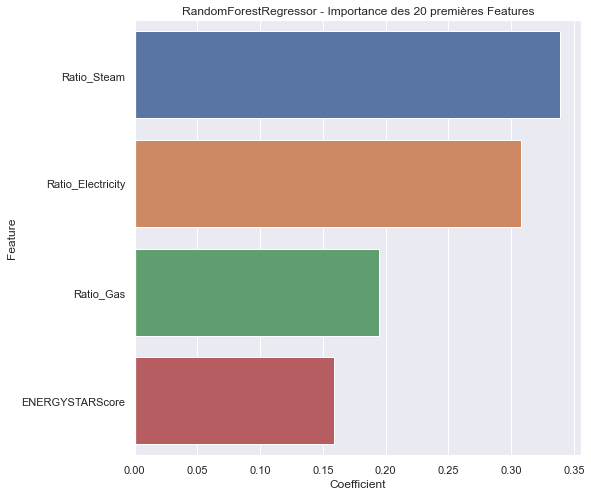

In [132]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Feature'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Random Forest GridSearchCV,0.99670,0.99341,0.75916,0.57563,0.45226
0,LASSO manually,1.15773,1.34034,0.93569,0.84865,0.26097
0,Ridge manually,1.15806,1.34111,0.93690,0.84755,0.26055
0,Elastic Net GridSearchCV,1.15956,1.34459,0.93796,0.84358,0.25863
0,Ridge GridSearchCV,1.15959,1.34466,0.93799,0.84348,0.25860
0,LASSO GridSearchCV,1.15962,1.34471,0.93802,0.84337,0.25857
0,Elastic Net RandomSearchCV,1.15966,1.34480,0.93805,0.84325,0.25852
0,Linear Regression,1.15966,1.34481,0.93806,0.84323,0.25851


Results Cross-Validated


,Model,Mean CV R²
0,Random Forest CV,0.48352
0,Elastic Net GridSearchCV,0.27536
0,Ridge Regression CV,0.27536
0,Elastic Net RandomSearchCV,0.27536
0,Linear Regression CV,0.27536
0,LASSO Regression CV,0.27534


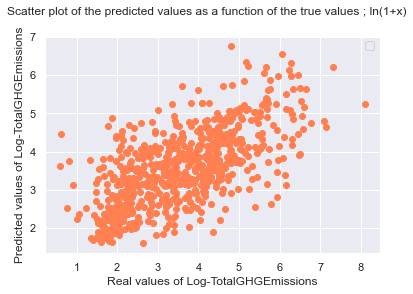

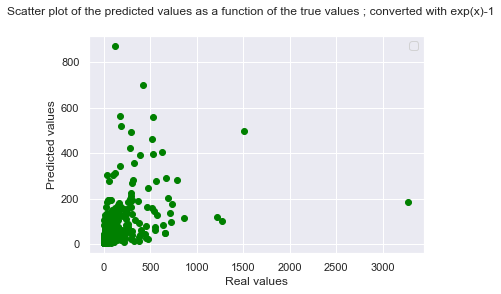

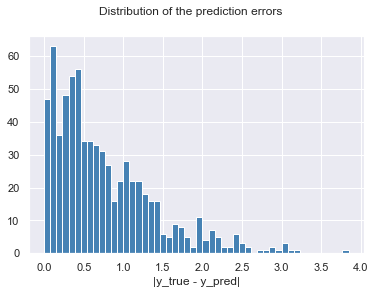

In [133]:
results = evaluate_regression("Random Forest GridSearchCV", results, y_test, y_pred_rfr)

results_cv = summary_results_cv("Random Forest CV", RandomForest_grid.best_score_, results_cv)

#### 2) Sequential method : XGBoost

GridSearchCV XGBoost Regressor
Best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Random Forest GridSearchCV,0.99670,0.99341,0.75916,0.57563,0.45226
0,XGBoost GridSearchCV,1.00446,1.00893,0.77140,0.60834,0.44371
0,LASSO manually,1.15773,1.34034,0.93569,0.84865,0.26097
0,Ridge manually,1.15806,1.34111,0.93690,0.84755,0.26055
0,Elastic Net GridSearchCV,1.15956,1.34459,0.93796,0.84358,0.25863
0,Ridge GridSearchCV,1.15959,1.34466,0.93799,0.84348,0.25860
0,LASSO GridSearchCV,1.15962,1.34471,0.93802,0.84337,0.25857
0,Elastic Net RandomSearchCV,1.15966,1.34480,0.93805,0.84325,0.25852
0,Linear Regression,1.15966,1.34481,0.93806,0.84323,0.25851


Results Cross-Validated


,Model,Mean CV R²
0,Random Forest CV,0.48352
0,XGBoost CV,0.47671
0,Elastic Net GridSearchCV,0.27536
0,Ridge Regression CV,0.27536
0,Elastic Net RandomSearchCV,0.27536
0,Linear Regression CV,0.27536
0,LASSO Regression CV,0.27534


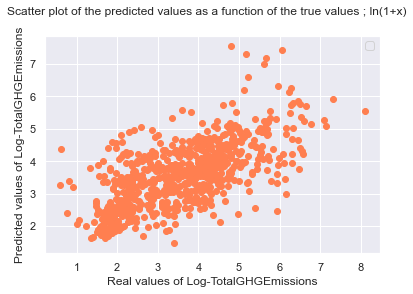

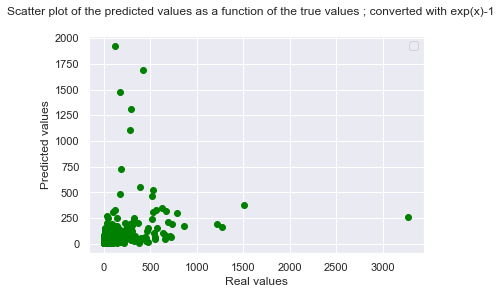

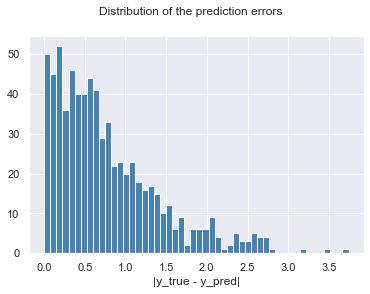

In [134]:
print("GridSearchCV XGBoost Regressor")

from xgboost import XGBRegressor
"""
param_grid_xgb = [{"learning_rate": (0.05, 0.10, 0.15),
                   "max_depth": [ 3, 4, 5, 6, 8],
                   "min_child_weight": [ 1, 3, 5, 7],
                   "gamma":[ 0.0, 0.1, 0.2],
                   "colsample_bytree":[ 0.3, 0.4],}]

XGBoost_grid = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=param_grid_xgb,
    cv=folds, scoring=scoring, verbose=0, n_jobs=-1, n_iter=100, random_state=seed)
"""
parameters = {
    'n_estimators' : [100,500,1000,2000],
    "learning_rate": (0.05, 0.10, 0.15),
    "gamma":[ 0.0, 0.1, 0.2]
}
XGBoost_grid = GridSearchCV(XGBRegressor(n_jobs=-1),
                              param_grid=parameters,
                              scoring=scoring,
                              cv=folds,
                              verbose=0,
                              n_jobs=-1)

#fit the grid search
XGBoost_grid.fit(X_train.values, y_train)

# best estimator
print("Best estimator :", XGBoost_grid.best_estimator_)

# best model
best_model = XGBoost_grid.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_xgbr = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("XGBoost GridSearchCV", results, y_test, y_pred_xgbr)
results_cv = summary_results_cv("XGBoost CV", XGBoost_grid.best_score_, results_cv)

### Evaluation

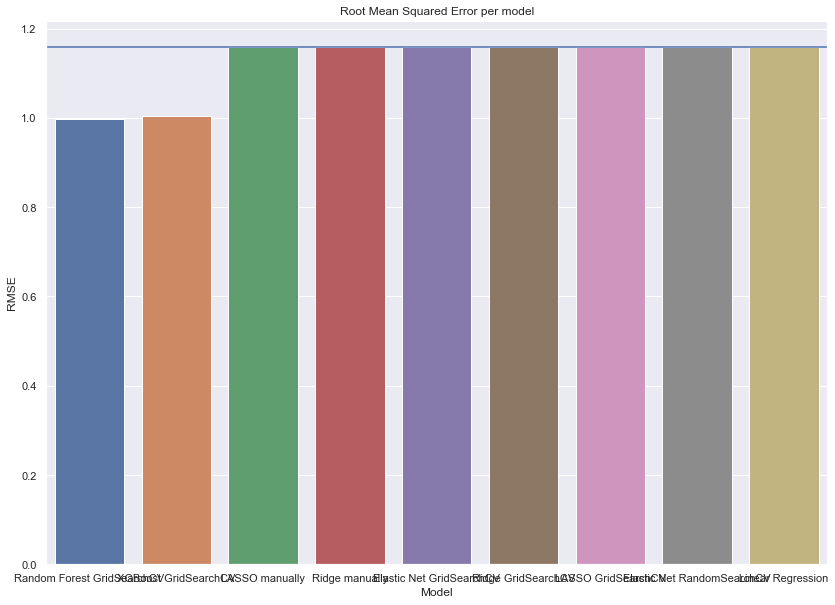

In [135]:
display_barplot_errors(results, baseline_model="Linear Regression", title="Root Mean Squared Error per model", metric="RMSE")

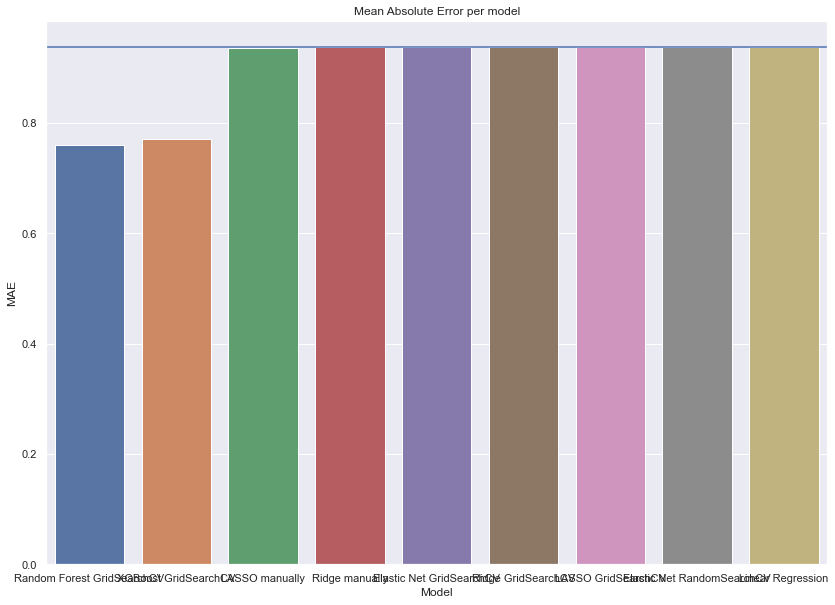

In [136]:
display_barplot_errors(results, baseline_model="Linear Regression", title="Mean Absolute Error per model", metric="MAE")

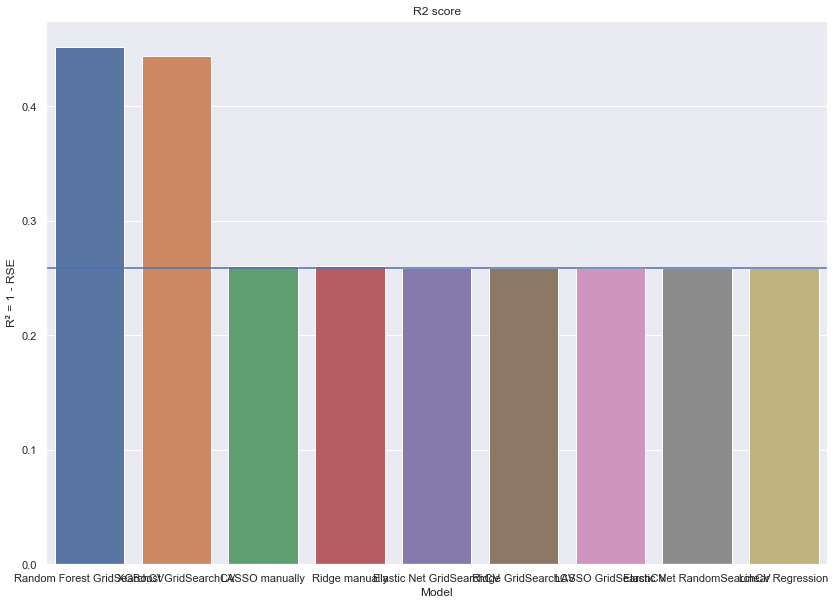

In [137]:
display_barplot_errors(results, baseline_model="Linear Regression", title="R2 score", metric="R² = 1 - RSE")

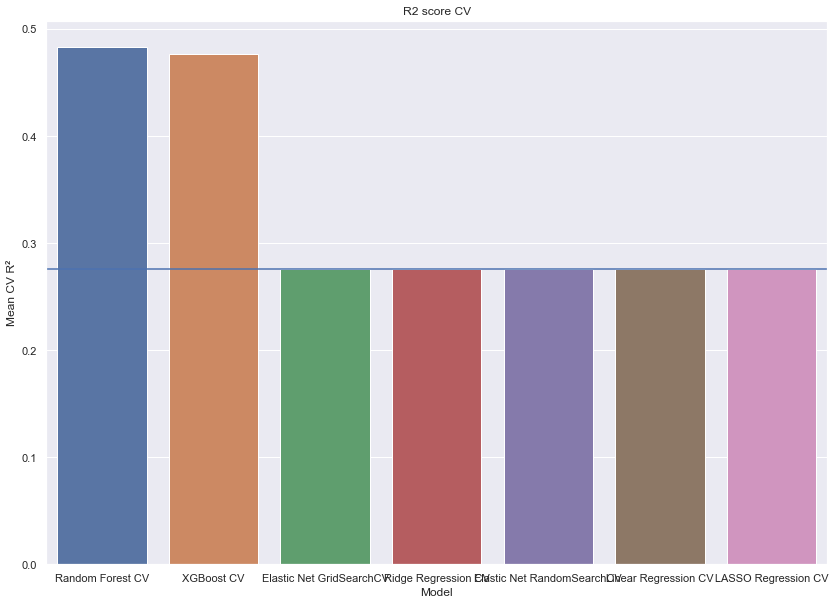

In [138]:
display_barplot_errors(results_cv, baseline_model="Linear Regression CV", title="R2 score CV", metric="Mean CV R²")

In [139]:
t1 = time()
print("computing time : {:8.6f} sec".format(t1-t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1-t0)))

computing time : 169.512159 sec
computing time : 00:02:49


##### We choose the best regressor

In [145]:
best_model = RandomForest_grid.best_estimator_

In [146]:
best_model

RandomForestRegressor(n_estimators=300, random_state=1)

In [147]:
dict_models = {
    'Ridge': Ridge_grid.best_estimator_,
    'Lasso': Lasso_grid.best_estimator_,
    'Elastic_Net': Elastic_GridSearch_grid.best_estimator_,
    'Random_Forest_Regressor': RandomForest_grid.best_estimator_,
    'XGBoost': XGBoost_grid.best_estimator_,
    'best_model_{}'.format(target_dir): best_model
}

In [148]:
for name, model in dict_models.items():
    filename = 'model/{}/'.format(target_dir) + name + '.sav'
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

#### We load the models saved locally and check their prediction time

['best_model_CO2_EnergyStarScore.sav', 'Elastic_Net.sav', 'Lasso.sav', 'Random_Forest_Regressor.sav', 'Ridge.sav', 'XGBoost.sav']
_____Prediction time for : best_model_CO2_EnergyStarScore_____
Prediction time : 0.068530 sec
_____Prediction time for : Elastic_Net_____
Prediction time : 0.008586 sec
_____Prediction time for : Lasso_____
Prediction time : 0.001475 sec
_____Prediction time for : Random_Forest_Regressor_____
Prediction time : 0.078046 sec
_____Prediction time for : Ridge_____
Prediction time : 0.002414 sec
_____Prediction time for : XGBoost_____
Prediction time : 0.002200 sec


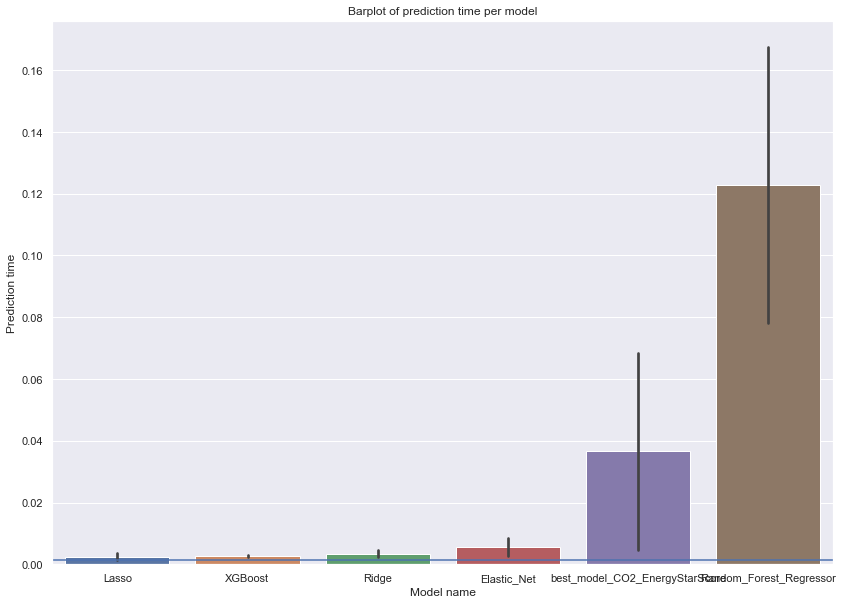

In [149]:
path_model = 'model/{}/'.format(target_dir)
all_models = [f for f in listdir(path_model) if isfile(join(path_model, f))]
print(all_models)

# load the model from disk
for model_name in all_models:
    filename = 'model/{}/'.format(target_dir) + model_name
    loaded_model = pickle.load(open(filename, 'rb'))
    print("_____Prediction time for :", model_name[:-4] + "_____")
    prediction_time = compute_prediction_time(loaded_model, model_name[:-4], X_test, prediction_time) # [:-3] removed .sav

display_barplot_prediction_time(prediction_time)